In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from oodles import Framework, monitor

In [2]:
#Read the training and test set
df = pd.read_csv("data/NSL-KDD/binary_train_test.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.1, 
                                                    test_size = 0.9, 
                                                    random_state = 0,
                                                    shuffle=False)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     69135
           1       0.99      0.93      0.96     64531

    accuracy                           0.96    133666
   macro avg       0.97      0.96      0.96    133666
weighted avg       0.96      0.96      0.96    133666

Accuracy: 0.9622417069411817


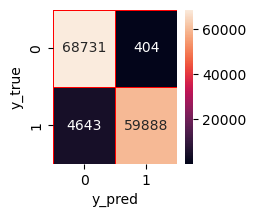

In [4]:
# Xgboost algorithm
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(2,2))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Define Prediction Function

In [5]:
framework = Framework()

@monitor(framework)
def model_predict(args):
    return args['model'].predict(args['x_test'])

#### Check for Data Drift

In [6]:
inputs = {'y_test': y_test}
acc = []
acc_sum = 0
for id, x_test in enumerate(X_test[0:1000]):
    x_test = np.expand_dims(x_test, axis=0)
    inputs.update({'model': classifier, 'id': id, 'x_test': x_test})
    y_pred = model_predict(inputs).item()
    if y_pred == y_test[id]:
        acc_sum += 1
    acc.append(acc_sum/(id + 1))

Concept drift detected


#### Plotting observed accuracy with time to check location of drifts

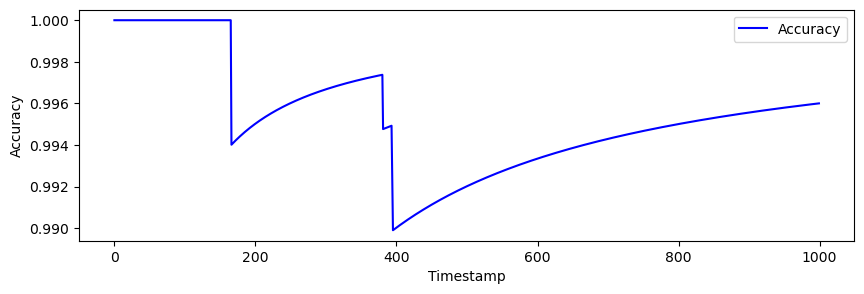

In [7]:
# Plot the accuracy changes
plt.rcParams.update({'font.size': 10})
plt.figure(1,figsize=(10,3)) 
plt.clf() 
plt.plot(acc,'-b',label='Accuracy')

plt.legend(loc='best')
plt.xlabel('Timestamp')
plt.ylabel('Accuracy')

plt.draw()